# Unsharp masking

$ F(Y) 
\\= F(X + a(X - G*X)) 
\\= F(X) + a(F(X) - F(G)F(X))
\\= (a+1)F(X) - a F(G)F(X) 
$


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from util import gaussian_lpf
from util import show_image

In [2]:
img_path = '/Users/jeonhyeonbin/Documents/CSED551/assn1/assn2/images/cat.jpg'

In [3]:
img_rgb = cv2.imread(img_path, cv2.IMREAD_COLOR).astype(np.float32)/255.         # RGB
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.    # grayscale

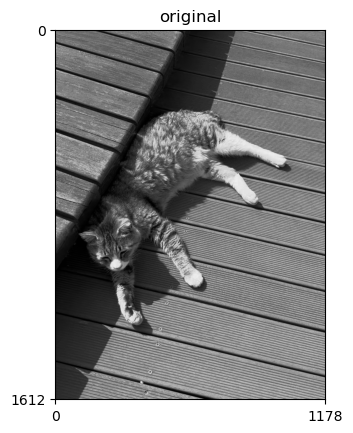

In [32]:
show_image(img_gray, 'original')

In [4]:
def unsharp_fourier_gray(img, cutoff, k=1.0, pad_size=10):
    M, N = img.shape
    padded_img = cv2.copyMakeBorder(img, pad_size, pad_size, pad_size, pad_size, borderType=cv2.BORDER_CONSTANT, value=0)

    P, Q = padded_img.shape
    
    f = np.fft.fft2(padded_img)     # 패딩한 이미지의 푸리에 변환
    f_s = np.fft.fftshift(f)        # 배열 변환    
    
    H_lpf = gaussian_lpf((P, Q), cutoff)
    
    # 저주파 성분 추출 (blurred 이미지)
    f_s_blurred = f_s * H_lpf
    
    # 고주파 성분 계산 (원본 - 저주파)
    f_s_high = f_s - f_s_blurred
    
    # Unsharp masking: 원본 + k * 고주파
    f_s_sharp = f_s + k * f_s_high
    
    # 역변환 과정
    filtered = np.fft.ifftshift(f_s_sharp)  # 주파수 원점 원위치
    img_filtered = np.fft.ifft2(filtered)   # 역푸리에 변환
    img_real = np.real(img_filtered)        # 실수부 추출 (허수부는 계산 오차로 무시 가능)
    
    # 패딩 제거 후 원본 크기로 자르기
    out = img_real[pad_size:pad_size+M, pad_size:pad_size+N]
    return out

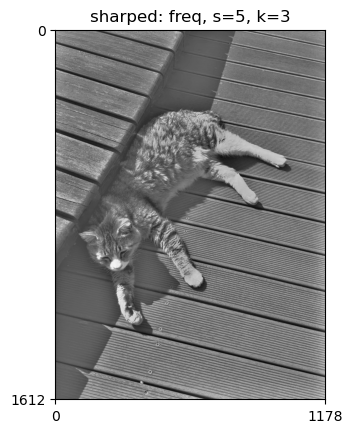

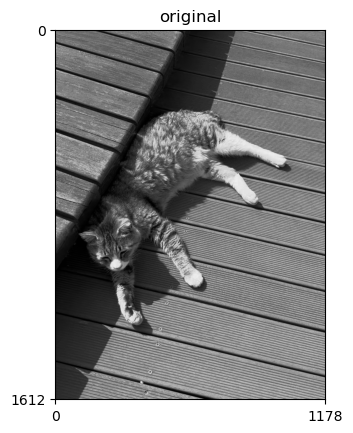

In [36]:
sharp_freq = unsharp_fourier_gray(img_gray, 5, k=3, pad_size=15)
show_image(sharp_freq, 'sharped: freq, s=5, k=3')
show_image(img_gray, 'original')

In [21]:
def unsharp_masking_spatial(img, kernel_size=5, sigma=1.0, k=1.0):
    # 입력 유효성 검사
    if len(img.shape) != 2:
        raise ValueError("입력 이미지는 그레이스케일(2D 배열)이어야 합니다.")
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size는 홀수여야 합니다.")

    # Gaussian 블러 적용으로 흐릿한 이미지 생성
    blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

    # 고주파 성분 계산: 원본 - 흐릿한 이미지
    high_freq = img - blurred_img

    # Unsharp masking: 원본 + k * 고주파
    sharpened = img + k * high_freq

    return sharpened

In [33]:
sharp_sp = unsharp_masking_spatial(img_gray, kernel_size=17, sigma=5, k=3.0)

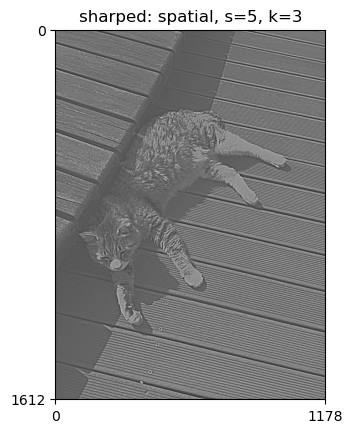

In [37]:
show_image(sharp_sp, 'sharped: spatial, s=5, k=3')

In [28]:
def subtract_images(img1, img2, output_path="difference.jpg", normalize=True):

    # 입력 이미지 크기 및 채널 확인
    if img1.shape != img2.shape:
        raise ValueError("두 이미지의 크기와 채널 수가 동일해야 합니다.")
    
    # 이미지 차이 계산 (float로 변환하여 오버플로우 방지)
    diff = img1.astype(float) - img2.astype(float)
    
    if normalize:
        # 차이를 절대값으로 변환 후 0~255로 정규화
        diff = np.abs(diff)
        diff = (diff / diff.max()) * 255  # 최대값 기준으로 스케일링
        diff = diff.astype(np.uint8)
    else:
        # 정규화 없이 절대값만 취함 (음수 제거)
        diff = np.abs(diff).astype(np.uint8)
    
    return diff

In [70]:
sub_sp = subtract_images(sharp_sp, img_gray)
sub_freq = subtract_images(sharp_freq, img_gray)

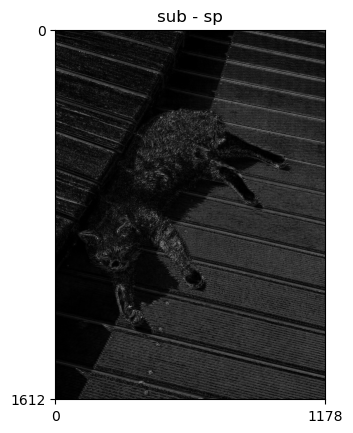

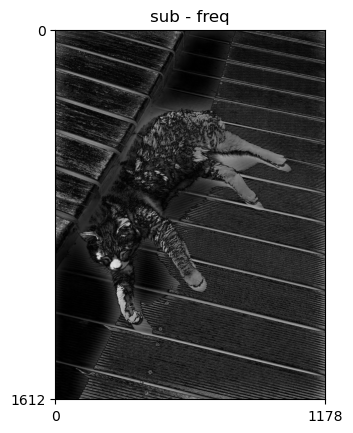

In [71]:
show_image(sub_sp, 'sub - sp')
show_image(sub_freq, 'sub - freq')

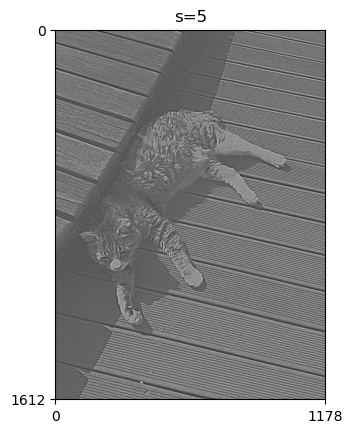

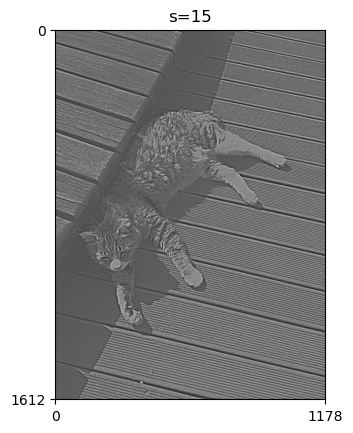

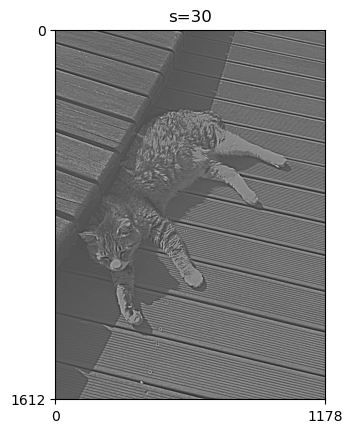

In [38]:

show_image(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=5, k=3.0), 's=5')
show_image(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=15, k=3.0), 's=15')
show_image(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=30, k=3.0), 's=30')

In [39]:
sub_30_5 = subtract_images(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=30, k=3.0), unsharp_masking_spatial(img_gray, kernel_size=17, sigma=5, k=3.0))

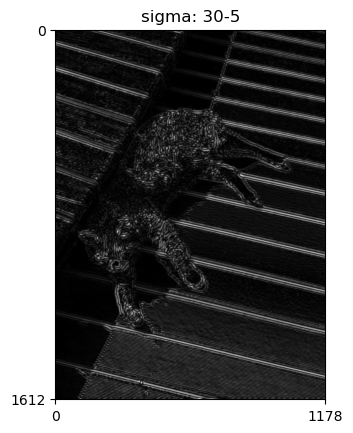

In [47]:
show_image(sub_30_5, 'sigma: 30-5')

In [41]:
sub_ori_3 = subtract_images(img_gray, unsharp_masking_spatial(img_gray, kernel_size=17, sigma=5, k=3.0))

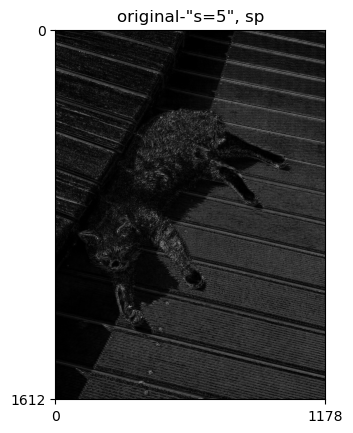

In [44]:
show_image(sub_ori_3, 'original-"s=5", sp')

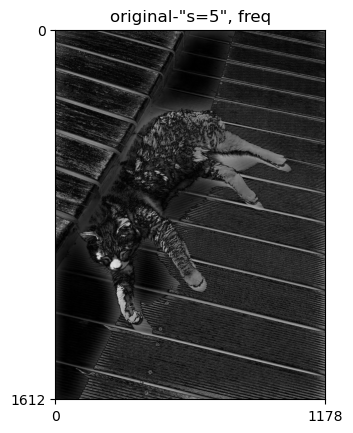

In [46]:
show_image(subtract_images(img_gray, unsharp_fourier_gray(img_gray,5, k=3.0)), 'original-"s=5", freq')

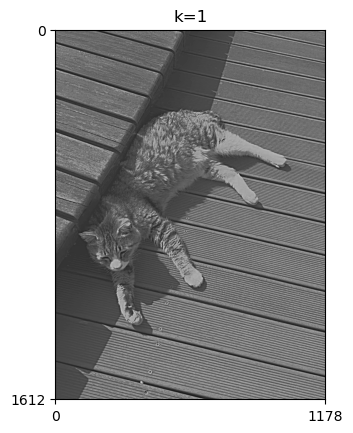

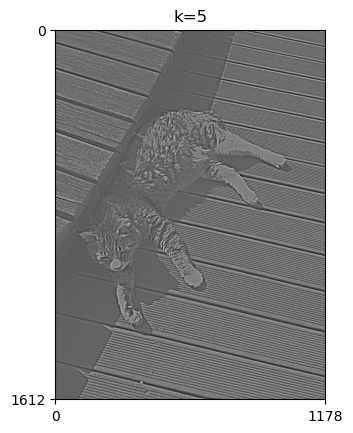

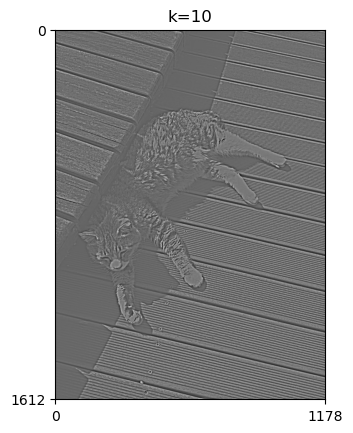

In [48]:

show_image(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=30, k=1.0), 'k=1')
show_image(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=30, k=5.0), 'k=5')
show_image(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=30, k=10.0), 'k=10')

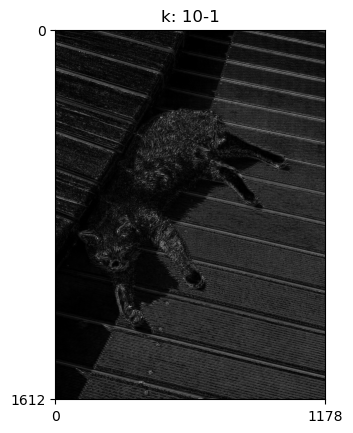

In [49]:
show_image(subtract_images(unsharp_masking_spatial(img_gray, kernel_size=17, sigma=30, k=10.0),unsharp_masking_spatial(img_gray, kernel_size=17, sigma=30, k=1.0)), 'k: 10-1')

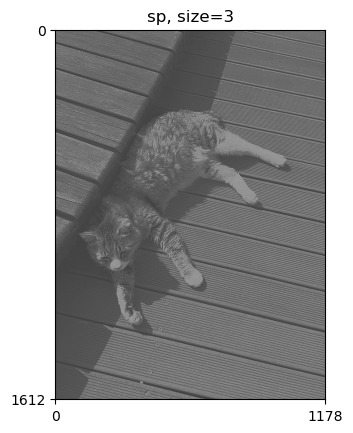

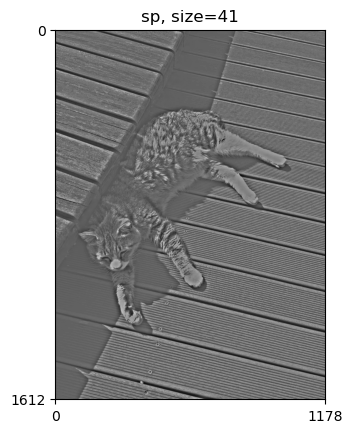

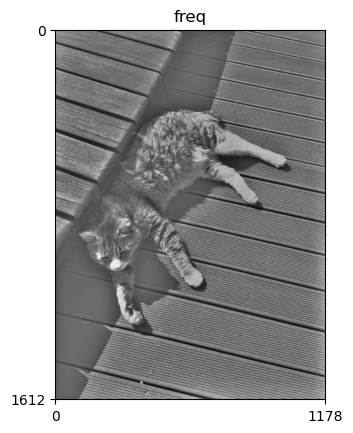

In [58]:
show_image(unsharp_masking_spatial(img_gray, kernel_size=3, sigma=30, k=5.0), 'sp, size=3')
show_image(unsharp_masking_spatial(img_gray, kernel_size=41, sigma=30, k=5.0), 'sp, size=41')
show_image(unsharp_fourier_gray(img_gray, 5.0, 15), 'freq')

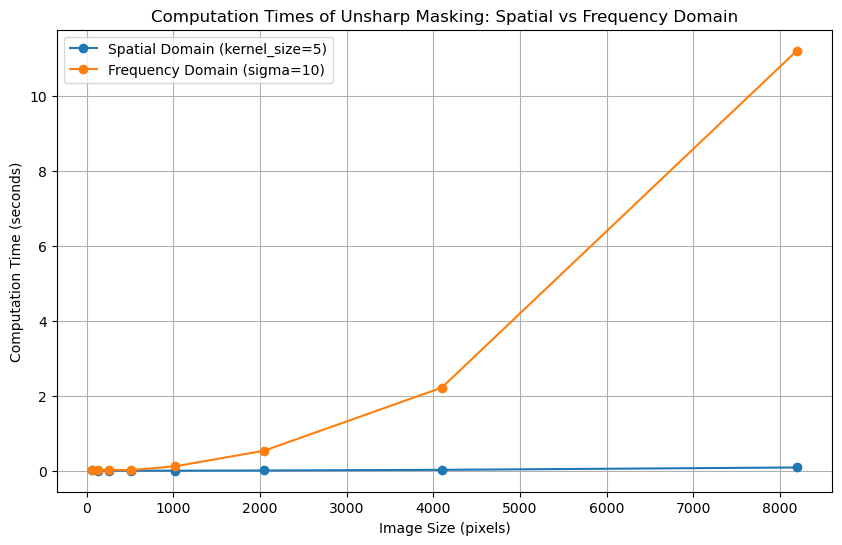

In [ ]:

import time
# 이미지 크기에 따른 계산 시간 측정
image_sizes = [64, 128, 256, 512, 1024, 2048, 4096, 4096*2]  # 테스트할 이미지 크기
times_spatial = []
times_frequency = []

# 기본 이미지 생성 (랜덤 노이즈 이미지 사용)
base_img = np.random.randint(0, 255, (1024, 1024), dtype=np.uint8)

for size in image_sizes:
    # 이미지 크기 조정
    img = cv2.resize(base_img, (size, size), interpolation=cv2.INTER_NEAREST)
    
    # 공간 도메인 실행 시간 측정
    start = time.time()
    _ = unsharp_masking_spatial(img, kernel_size=5, sigma=1.0, k=1.5)
    elapsed_spatial = time.time() - start
    times_spatial.append(elapsed_spatial)
    
    # 주파수 도메인 실행 시간 측정
    start = time.time()
    _ = unsharp_fourier_gray(img, 10.0, k=1.5, pad_size=50)
    elapsed_frequency = time.time() - start
    times_frequency.append(elapsed_frequency)

# 결과를 그래프로 표시
plt.figure(figsize=(10, 6))
plt.plot(image_sizes, times_spatial, marker='o', label='Spatial Domain (kernel_size=5)')
plt.plot(image_sizes, times_frequency, marker='o', label='Frequency Domain (sigma=10)')
plt.xlabel("Image Size (pixels)")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Times of Unsharp Masking: Spatial vs Frequency Domain")
plt.legend()
plt.grid(True)
plt.show()

In [62]:
import numpy as np

# 2D Gaussian 커널 생성 함수
def create_gaussian_kernel(kernel_size, sigma):
    """Gaussian 커널을 생성합니다."""
    # 커널 크기가 홀수인지 확인
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size는 홀수여야 합니다.")
    
    # 중심을 기준으로 좌표 생성
    ax = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    # Gaussian 공식 적용
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    # 정규화 (총합이 1이 되도록)
    return kernel / kernel.sum()

# 직접 컨볼루션 수행 함수
def convolve2d(image, kernel):
    """NumPy로 2D 컨볼루션을 수행합니다."""
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    # 경계 처리를 위해 패딩 추가 (대칭 패딩)
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='symmetric')
    output = np.zeros_like(image, dtype=float)
    
    # 컨볼루션 수행
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i, j] = np.sum(padded_img[i:i+kh, j:j+kw] * kernel)
    
    return output

# unsharp masking 함수 (OpenCV 없이)
def unsharp_masking_spatial_noOpenCV(img, kernel_size, sigma, k=1.5):
    # 입력 유효성 검사
    if len(img.shape) != 2:
        raise ValueError("입력 이미지는 그레이스케일(2D 배열)이어야 합니다.")
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size는 홀수여야 합니다.")
    
    # Gaussian 커널 생성
    kernel = create_gaussian_kernel(kernel_size, sigma)
    
    # Gaussian 블러 적용
    blurred_img = convolve2d(img, kernel)
    
    # float로 변환하여 연산
    img_float = img.astype(float)
    blurred_float = blurred_img.astype(float)
    
    # 고주파 성분 계산: 원본 - 흐릿한 이미지
    high_freq = img_float - blurred_float
    
    # Unsharp masking: 원본 + k * 고주파
    sharpened = img_float + k * high_freq
    
    # 0~255 범위로 클리핑하고 uint8로 변환
    #sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    return sharpened



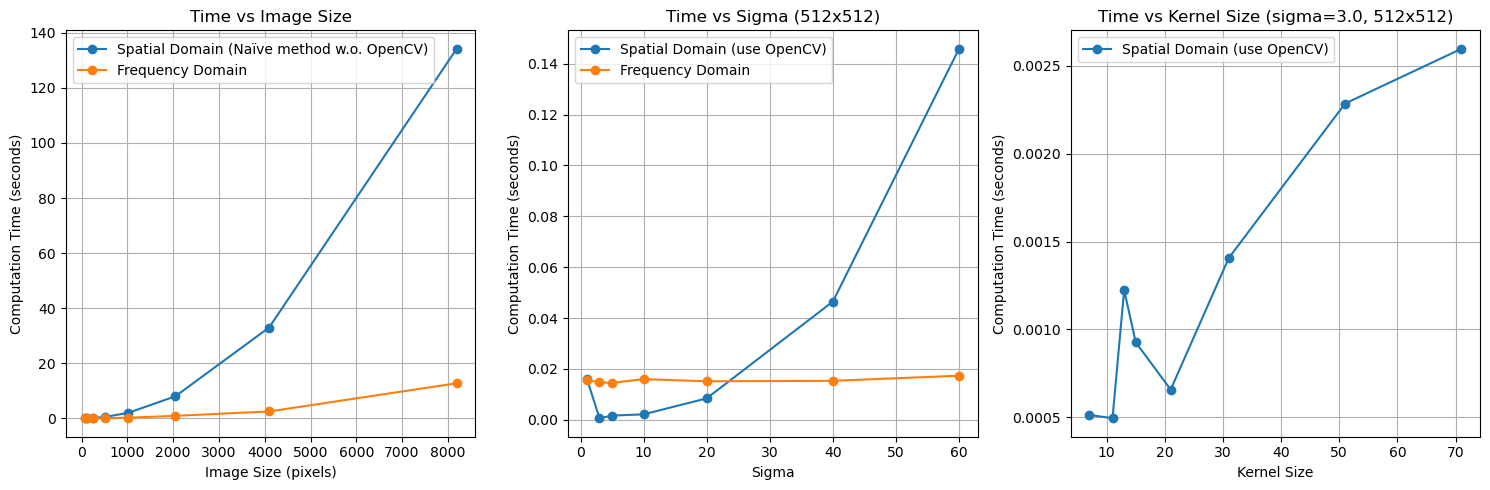

In [69]:

import time

# 기본 이미지 생성 (랜덤 노이즈 이미지)
base_img = np.random.randint(0, 255, (1024, 1024), dtype=np.uint8)

# (1) 이미지 크기에 따른 계산 시간 비교
image_sizes = [64, 128, 256, 512, 1024, 1024*2, 1024*4, 1024*8] # 최대가 2^13
times_spatial_size = []
times_frequency_size = []

for size in image_sizes:
    img = cv2.resize(base_img, (size, size), interpolation=cv2.INTER_NEAREST)
    
    start = time.time()
    _ = unsharp_masking_spatial_noOpenCV(img, kernel_size=3, sigma=1.0, k=1.5)
    times_spatial_size.append(time.time() - start)
    
    start = time.time()
    _ = unsharp_fourier_gray(img, 10.0, k=1.5, pad_size=50)
    times_frequency_size.append(time.time() - start)

# (2) Sigma에 따른 계산 시간 비교 (이미지 크기 512x512 고정)
sigma_values = [1.0, 3.0, 5.0, 10.0, 20.0, 40, 60]
times_spatial_sigma = []
times_frequency_sigma = []
img_512 = cv2.resize(base_img, (512, 512), interpolation=cv2.INTER_NEAREST)

for sigma in sigma_values:
    kernel_size = int(2 * np.ceil(3 * sigma) + 1)  # sigma에 맞춘 커널 크기
    start = time.time()
    _ = unsharp_masking_spatial(img_512, kernel_size, sigma, k=1.5)
    times_spatial_sigma.append(time.time() - start)
    
    start = time.time()
    _ = unsharp_fourier_gray(img_512, sigma, k=1.5, pad_size=50)
    times_frequency_sigma.append(time.time() - start)

# (3) 공간 도메인에서 커널 크기에 따른 계산 시간 비교 (sigma=3.0, 이미지 크기 512x512)
kernel_sizes = [7, 11, 13, 15, 21, 31, 51, 71]
times_spatial_kernel = []

for k_size in kernel_sizes:
    start = time.time()
    _ = unsharp_masking_spatial(img_512, kernel_size=k_size, sigma=3.0, k=1.5)
    times_spatial_kernel.append(time.time() - start)

# 그래프 플롯
plt.figure(figsize=(15, 5))

# (1) 이미지 크기 비교
plt.subplot(1, 3, 1)
plt.plot(image_sizes, times_spatial_size, marker='o', label='Spatial Domain (Naïve method w.o. OpenCV)')
plt.plot(image_sizes, times_frequency_size, marker='o', label='Frequency Domain')
plt.xlabel("Image Size (pixels)")
plt.ylabel("Computation Time (seconds)")
plt.title("Time vs Image Size")
plt.legend()
plt.grid(True)

# (2) Sigma 비교
plt.subplot(1, 3, 2)
plt.plot(sigma_values, times_spatial_sigma, marker='o', label='Spatial Domain (use OpenCV)')
plt.plot(sigma_values, times_frequency_sigma, marker='o', label='Frequency Domain')
plt.xlabel("Sigma")
plt.ylabel("Computation Time (seconds)")
plt.title("Time vs Sigma (512x512)")
plt.legend()
plt.grid(True)

# (3) 커널 크기 비교 (공간 도메인만)
plt.subplot(1, 3, 3)
plt.plot(kernel_sizes, times_spatial_kernel, marker='o', label='Spatial Domain (use OpenCV)')
plt.xlabel("Kernel Size")
plt.ylabel("Computation Time (seconds)")
plt.title("Time vs Kernel Size (sigma=3.0, 512x512)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()